In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb
df = pd.read_csv('X_G.txt', sep='\s+')
obs = torch.tensor(df.values)

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available():
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev) 

2.1.2+cu121
True
NVIDIA A10


In [3]:
obs = np.array(0)
obs = np.append(obs, df.values[:,1])
obs = torch.tensor(obs, dtype = torch.float32)
obs = torch.reshape(obs, (1, obs.size()[0]))

In [4]:
obs.size()

torch.Size([1, 501])

In [5]:
#### Number of data points
#S = 500

# time inteval
delta = 1

#n = int(S/delta)
n = 500
y0 = 0
# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

501


In [6]:
# Data import
# Default : cuda
torch.set_default_device(device)

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "../../../depot_hyun/hyun/Comparison/Comparison1/Comparison1_sim" + str(j) +".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output_raw = torch.cat(output_raw, dim = 0)

X_raw = X_raw.to(device)
output_raw = output_raw.to(device)

X_raw = X_raw.to("cpu")

a = torch.quantile(X_raw, .001, 0)
a = torch.reshape(a, (1, a.size()[0]))
b = torch.quantile(X_raw, .999, 0)
b = torch.reshape(b, (1, b.size()[0]))

output = []
output.append(output_raw[:,0])
output.append(output_raw[:,1])
output.append(output_raw[:,2])
output.append(torch.log(output_raw[:,3]))
output.append(torch.log(output_raw[:,4]))
output = torch.column_stack(output)

X = torch.clone((X_raw - a) / (b - a))
torch.set_default_device(dev)
X = X.to(dev)
output = output.to(dev)



L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'Compare1_MOUJ_sigma.pt'
path = F"./{model_save_name}"

torch.Size([450000, 44]) torch.Size([40000, 44]) torch.Size([10000, 44])


In [7]:
output.size()

torch.Size([500000, 5])

In [8]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.0914, device='cuda:0') tensor(-2.0270) tensor(2.0808)
1 tensor(1.0919, device='cuda:0') tensor(-2.0230) tensor(2.0767)
2 tensor(2.4912, device='cuda:0') tensor(1.2076e-06) tensor(0.0049)
3 tensor(2.2794, device='cuda:0') tensor(3.9181e-06) tensor(0.0089)
4 tensor(2.2721, device='cuda:0') tensor(7.0605e-06) tensor(0.0089)
5 tensor(1.4267, device='cuda:0') tensor(0.0318) tensor(1.6864)
6 tensor(2.0104, device='cuda:0') tensor(7.8922e-06) tensor(0.0089)
7 tensor(17.0958, device='cuda:0') tensor(-0.0018) tensor(0.0061)
8 tensor(43.0153, device='cuda:0') tensor(8.3390e-10) tensor(0.0003)
9 tensor(20.2293, device='cuda:0') tensor(-0.0014) tensor(0.0094)
10 tensor(56.0759, device='cuda:0') tensor(2.5852e-10) tensor(0.0002)
11 tensor(1.1542, device='cuda:0') tensor(0.0372) tensor(0.6554)
12 tensor(1.0834, device='cuda:0') tensor(-1.7334) tensor(1.7522)
13 tensor(1., device='cuda:0') tensor(0.9960) tensor(0.9980)
14 tensor(1., device='cuda:0') tensor(0.9940) tensor(0.9980)
15 tensor(

In [9]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [10]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [11]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([0.4632, 0.0651, 0.0475, 0.0269, 0.2976], device='cuda:0')


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 1.373833  [   64/450000]
train_loss: 0.099357  [64064/450000]
train_loss: 0.080948  [128064/450000]
train_loss: 0.103718  [192064/450000]
train_loss: 0.094860  [256064/450000]
train_loss: 0.093403  [320064/450000]
train_loss: 0.100293  [384064/450000]
train_loss: 0.099980  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.087697 val_loss 0.087726
train_loss: 0.074690  [   64/450000]
train_loss: 0.105463  [64064/450000]
train_loss: 0.082572  [128064/450000]
train_loss: 0.082568  [192064/450000]
train_loss: 0.074590  [256064/450000]
train_loss: 0.086317  [320064/450000]
train_loss: 0.085976  [384064/450000]
train_loss: 0.095257  [448064/450000]
Epoch 11
-------------------------------
train_loss 0.082729 val_loss 0.082792
train_loss: 0.085251  [   64/450000]
train_loss: 0.063522  [64064/450000]
train_loss: 0.071826  [128064/450000]
train_loss: 0.095776  [192064/450000]
train_loss: 0.088866  [256064/450000]
train_loss: 0.082639  [320064/450000]
train_loss: 0

train_loss: 0.086758  [320064/450000]
train_loss: 0.074307  [384064/450000]
train_loss: 0.083598  [448064/450000]
Epoch 211
-------------------------------
train_loss 0.081216 val_loss 0.082586
train_loss: 0.133660  [   64/450000]
train_loss: 0.077701  [64064/450000]
train_loss: 0.100892  [128064/450000]
train_loss: 0.074065  [192064/450000]
train_loss: 0.066661  [256064/450000]
train_loss: 0.094012  [320064/450000]
train_loss: 0.081848  [384064/450000]
train_loss: 0.061313  [448064/450000]
Epoch 221
-------------------------------
train_loss 0.080949 val_loss 0.083022
train_loss: 0.079270  [   64/450000]
train_loss: 0.073093  [64064/450000]
train_loss: 0.059099  [128064/450000]
train_loss: 0.076434  [192064/450000]
train_loss: 0.085943  [256064/450000]
train_loss: 0.069221  [320064/450000]
train_loss: 0.083340  [384064/450000]
train_loss: 0.081173  [448064/450000]
Epoch 231
-------------------------------
train_loss 0.081326 val_loss 0.084044
train_loss: 0.066085  [   64/450000]
train

In [ ]:
print(np.min(val_error_plt))

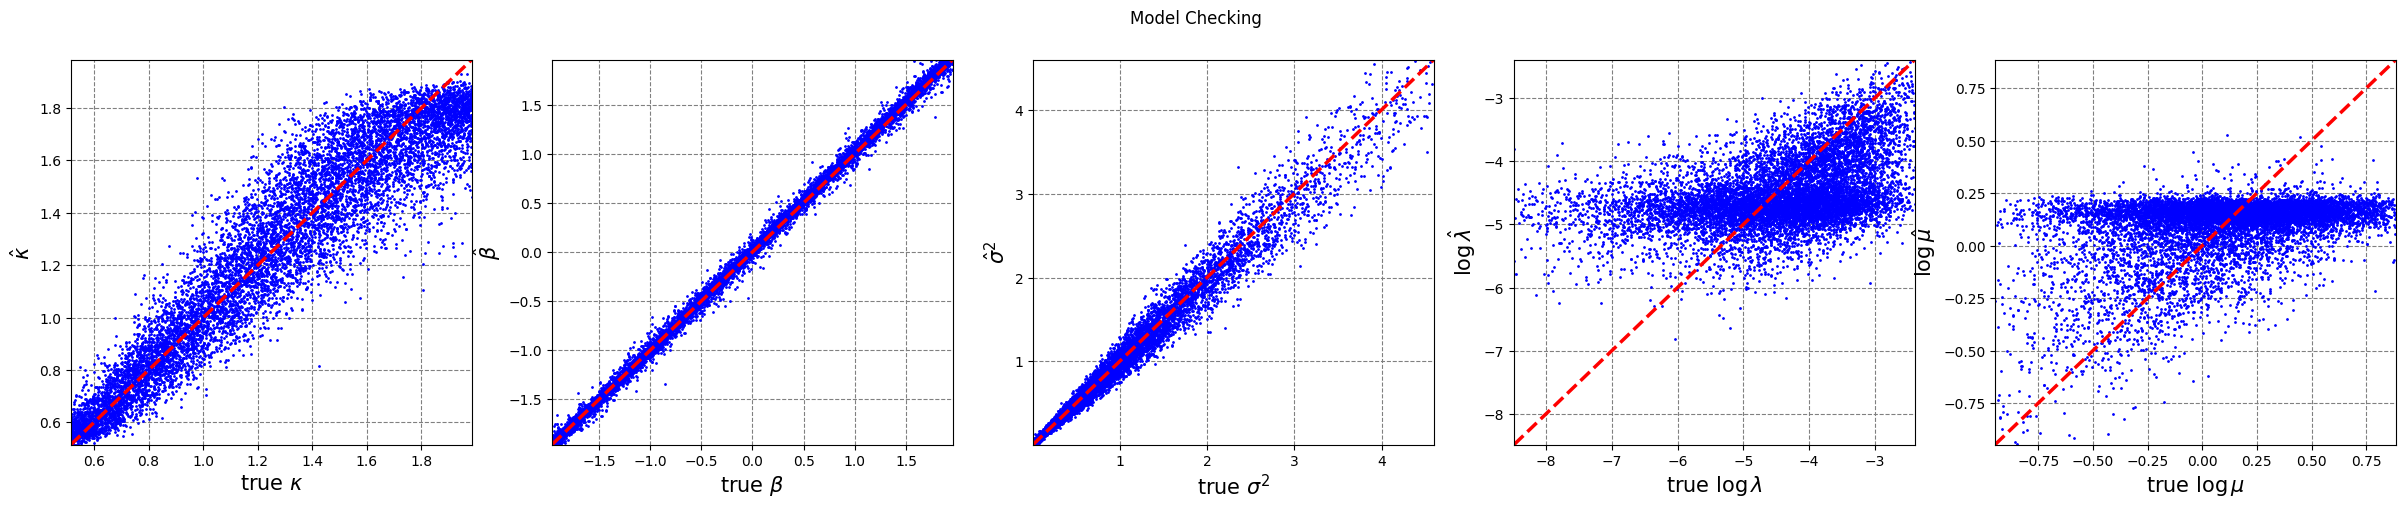

In [12]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\log\lambda$', r'true $\log\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\log\hat{\lambda}$', r'$\log\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    
plt.show()

In [13]:
torch.set_default_device("cpu")
net = net.to("cpu")
df = pd.read_csv('X_G.txt', sep='\s+')
obs = torch.tensor(df.values)
obs = np.array(0)
obs = np.append(obs, df.values[:,1])
obs = torch.tensor(obs, dtype = torch.float32)
obs = torch.reshape(obs, (1, obs.size()[0]))

obs = MROUJ_summary2(obs)

obs = torch.clone((obs - a) / (b - a))
print(net(obs))
print(torch.exp(net(obs)))


tensor([[ 0.9490,  0.1202,  0.8575, -3.0778, -0.2992]],
       grad_fn=<AddmmBackward0>)
tensor([[2.5831, 1.1277, 2.3572, 0.0461, 0.7414]], grad_fn=<ExpBackward0>)


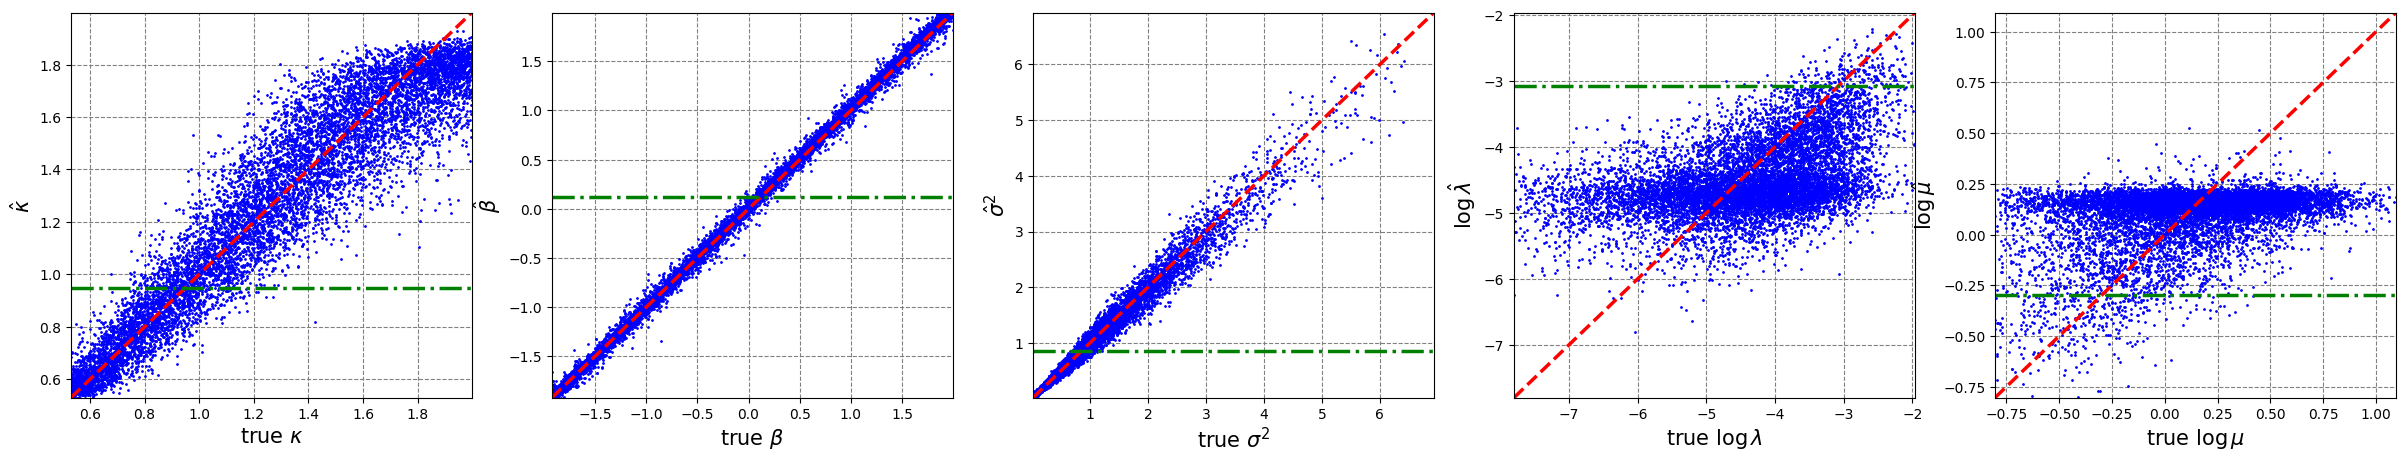

In [14]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\log\lambda$', r'true $\log\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\log\hat{\lambda}$', r'$\log\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.02, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.999, 0).detach().cpu().numpy()

est = np.concatenate(net(obs).detach().cpu().numpy())

fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
#fig.suptitle('Learning Checking', fontsize = 40)

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    axes[i].axhline(y = est[i], color = 'green', linestyle = '-.', linewidth = 2.5) 
    

plt.show()

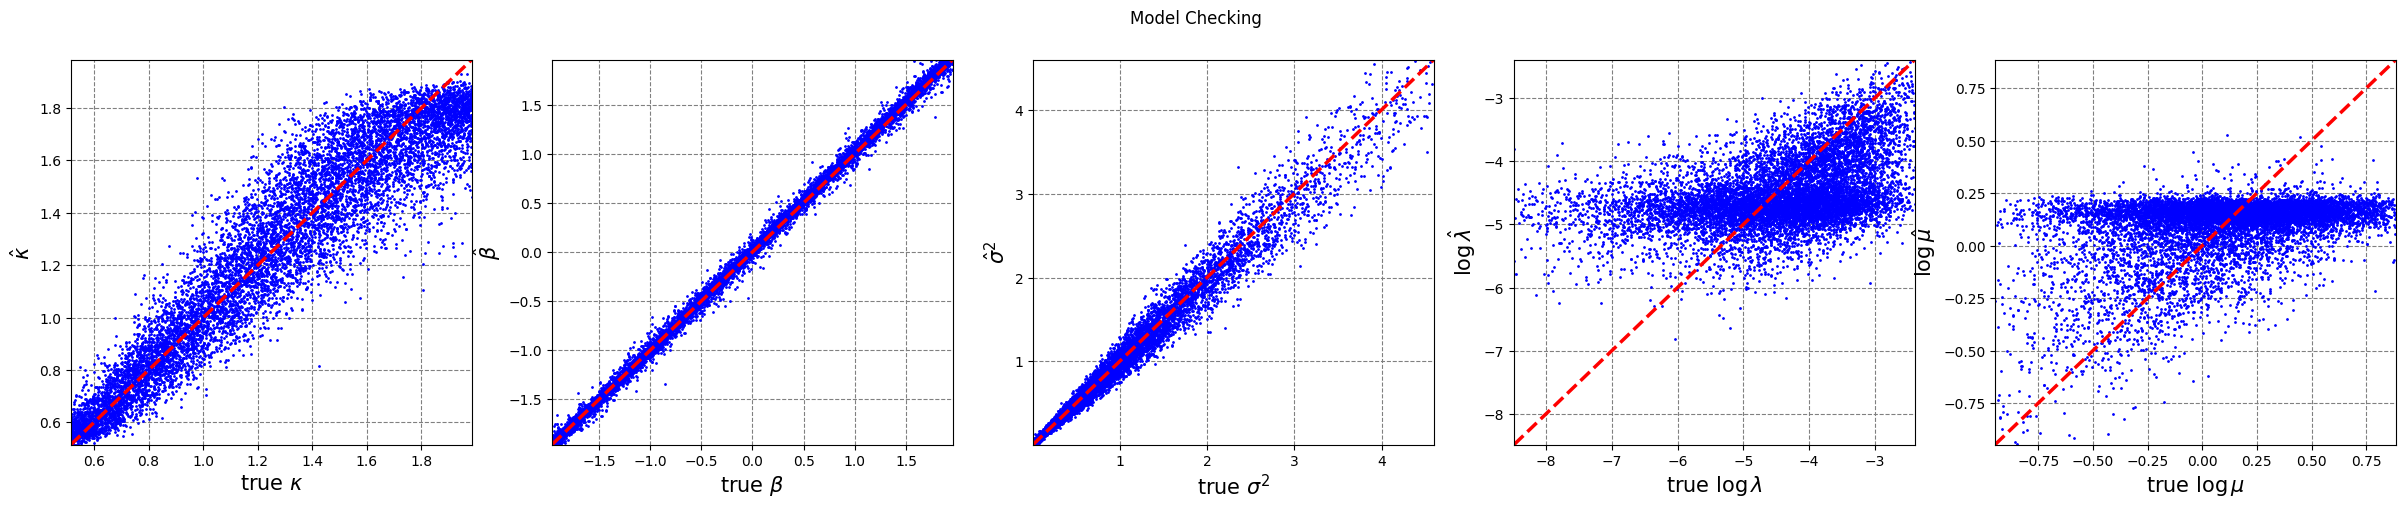

In [15]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\log\lambda$', r'true $\log\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\log\hat{\lambda}$', r'$\log\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    
plt.show()

In [16]:
results = net(obs.to("cpu")).detach()
results = torch.cat((results[:,0], results[:,1], results[:,2], torch.exp(results[:,3]), torch.exp(results[:,4])))
print(results)

tensor([0.9490, 0.1202, 0.8575, 0.0461, 0.7414])


In [17]:
path_cal = "../../../depot_hyun/hyun/Comparison/Comparison1/Comparison1_sim"
    
X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))


output_cal = []
output_cal.append(y_cal[:,0])
output_cal.append(y_cal[:,1])
output_cal.append(y_cal[:,2])
output_cal.append(torch.log(y_cal[:,3]))
output_cal.append(torch.log(y_cal[:,4]))

output_cal = torch.column_stack(output_cal)

In [18]:
net.eval()
results3 = conf_inf_sd(obs, X_cal, output_cal, net, .03)

train_loss: 0.126671  [   64/73500]
train_loss: 0.108832  [ 6464/73500]
train_loss: 0.102132  [12864/73500]
train_loss: 0.108232  [19264/73500]
train_loss: 0.091575  [25664/73500]
train_loss: 0.067505  [32064/73500]
train_loss: 0.080449  [38464/73500]
train_loss: 0.080026  [44864/73500]
train_loss: 0.066494  [51264/73500]
train_loss: 0.066358  [57664/73500]
train_loss: 0.058271  [64064/73500]
train_loss: 0.048035  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.057872 val_loss 0.058448
Epoch 31
-------------------------------
train_loss 0.025261 val_loss 0.026226
train_loss: 0.024666  [   64/73500]
train_loss: 0.024032  [ 6464/73500]
train_loss: 0.023261  [12864/73500]
train_loss: 0.031005  [19264/73500]
train_loss: 0.018665  [25664/73500]
train_loss: 0.022912  [32064/73500]
train_loss: 0.024705  [38464/73500]
train_loss: 0.026126  [44864/73500]
train_loss: 0.026849  [51264/73500]
train_loss: 0.020847  [57664/73500]
train_loss: 0.029376  [64064/73500]
train_loss: 0.0

In [19]:
net.eval()
results4 = conf_inf_sd(obs, X_cal, output_cal, net, .04)

train_loss: 0.211073  [   64/98000]
train_loss: 0.180895  [ 6464/98000]
train_loss: 0.195438  [12864/98000]
train_loss: 0.180110  [19264/98000]
train_loss: 0.166472  [25664/98000]
train_loss: 0.153803  [32064/98000]
train_loss: 0.149364  [38464/98000]
train_loss: 0.124178  [44864/98000]
train_loss: 0.116717  [51264/98000]
train_loss: 0.121174  [57664/98000]
train_loss: 0.117880  [64064/98000]
train_loss: 0.108243  [70464/98000]
train_loss: 0.097614  [76864/98000]
train_loss: 0.084508  [83264/98000]
train_loss: 0.094072  [89664/98000]
train_loss: 0.081279  [96064/98000]
Epoch 1
-------------------------------
train_loss 0.081489 val_loss 0.081162
Epoch 31
-------------------------------
train_loss 0.034669 val_loss 0.035019
train_loss: 0.028376  [   64/98000]
train_loss: 0.035970  [ 6464/98000]
train_loss: 0.031004  [12864/98000]
train_loss: 0.035581  [19264/98000]
train_loss: 0.029326  [25664/98000]
train_loss: 0.032376  [32064/98000]
train_loss: 0.027769  [38464/98000]
train_loss: 0.0

In [20]:
net.eval()
results5 = conf_inf_sd(obs, X_cal, output_cal, net, .05)

train_loss: 0.193037  [   64/122499]
train_loss: 0.204250  [ 6464/122499]
train_loss: 0.160416  [12864/122499]
train_loss: 0.156614  [19264/122499]
train_loss: 0.152584  [25664/122499]
train_loss: 0.149571  [32064/122499]
train_loss: 0.134598  [38464/122499]
train_loss: 0.128991  [44864/122499]
train_loss: 0.113964  [51264/122499]
train_loss: 0.099116  [57664/122499]
train_loss: 0.102142  [64064/122499]
train_loss: 0.090924  [70464/122499]
train_loss: 0.094418  [76864/122499]
train_loss: 0.089761  [83264/122499]
train_loss: 0.087866  [89664/122499]
train_loss: 0.084442  [96064/122499]
train_loss: 0.063736  [102464/122499]
train_loss: 0.078139  [108864/122499]
train_loss: 0.058037  [115264/122499]
train_loss: 0.060488  [121664/122499]
Epoch 1
-------------------------------
train_loss 0.063273 val_loss 0.063184
Epoch 31
-------------------------------
train_loss 0.031515 val_loss 0.032062
train_loss: 0.030312  [   64/122499]
train_loss: 0.029998  [ 6464/122499]
train_loss: 0.042303  [12

In [21]:
torch.save([results3, results4, results5], "./results/Comparison1_infer.pt")
#[results3, results4,results5] = torch.load("./results/Comparison1_infer.pt")

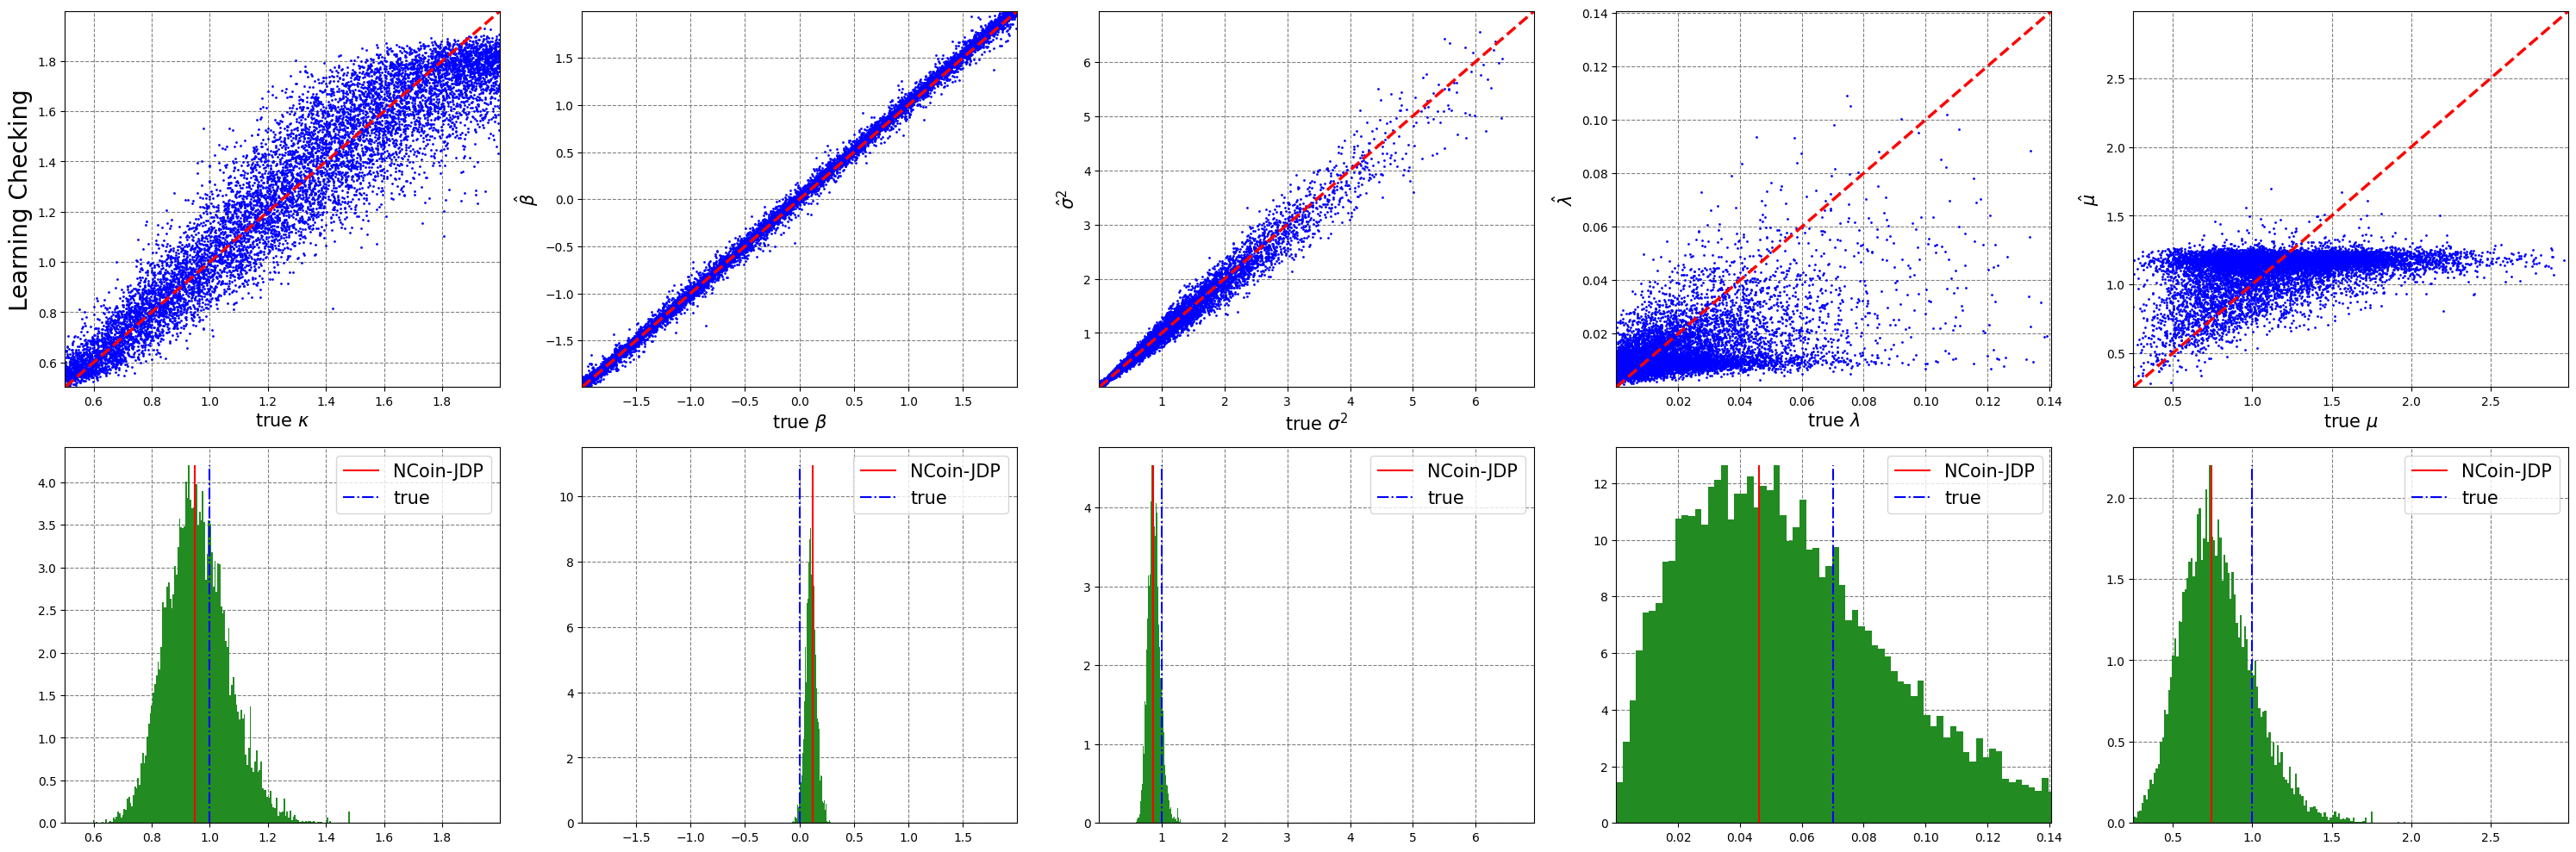

In [22]:
import matplotlib.pyplot as plt
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\hat{\lambda}$', r'$\hat{\mu}$']

#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']
true_param = [1, 0, 1, 0.07, 1]

exp_ind = [3, 4]

# First sample
est = net(obs).detach()[0]
weights = np.copy(results5[0].detach().cpu().numpy())    
samples = np.copy(results5[1].detach().cpu().numpy())

for j in exp_ind:
    est[j] = np.exp(est[j])
    samples[:,j] = np.exp(samples[:,j])

with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking
lim_left = torch.quantile(output,.001, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.999, 0).detach().cpu().numpy()

for i in exp_ind:
    lim_left[i] = np.exp(lim_left[i])
    lim_right[i] = np.exp(lim_right[i])


fig, axs = plt.subplots(2, len(tmp[0]), figsize=(30,10))


for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    tmp1 = tmp[:, i]
    if i in exp_ind:
        axs[0, i].scatter(torch.exp(y_test[:,i]), np.exp(tmp1), marker='o', color='b', s= 1)
    else:
        axs[0, i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axs[0,i].set_xlabel(true_name[i], fontsize=15)
    axs[0,i].set_ylabel(esti_name[i], fontsize=15)
    axs[0,i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axs[0,i].set_axisbelow(True)
    axs[0,i].grid(color='gray', linestyle='dashed')
    axs[0,i].set_ylim([lim0, lim1])
    axs[0,i].set_xlim([lim0, lim1])
    axs[0,0].set_ylabel("Learning Checking", fontsize = 20)


for i in range(len(true_name)):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    #if i in exp_ind:
    #    lim0 = np.exp(lim0); lim1 = np.exp(lim1)
    y, x, _ = axs[1,i].hist(samples[:,i], density=True, weights = weights, bins = 200, color = "forestgreen")
    axs[1, i].set_axisbelow(True)
    axs[1, i].grid(color='gray', linestyle='dashed')
    axs[1, i].set_xlim([lim0, lim1])
    axs[1, i].vlines(est[i], 0, max(y), color = 'red')
    axs[1, i].vlines(true_param[i], 0, max(y), color = 'blue', linestyle ="dashdot")
    axs[1, i].legend(['NCoin-JDP', 'true'], loc = "upper right", fontsize=15) 
fig.tight_layout()
#fig.savefig("../JD_plots/OUJ_infer.pdf") 

In [23]:
true_param = [1, 0, 1, 0.07, 1]
results_list = torch.load("./results/Comparison1_infer.pt")
print(len(results_list))
exp_ind = [3, 4]
size = 100000

sam = []
for j in range(len(true_param)):
    sam_1 = []
    for i in range(len(results_list)):
        results = results_list[i]
        samples_1 = []
        if j in exp_ind:
            samples_1.append(np.exp(results[1][:,j].detach().cpu().numpy()))
        else:
            samples_1.append(results[1][:,j].detach().cpu().numpy())
        vec = samples_1[0]
        
        np.random.seed(1)
        weights = np.copy(results[0].detach().cpu().numpy())
        P = weights/weights.sum()
        
        sam_2 = np.random.choice(vec,size,replace=True, p=P)
        sam_1.append(sam_2)
    sam.append(sam_1)

3


In [62]:
for j in range(len(true_param)):
    tmp = np.concatenate(sam[j])
    if j == 2:
        tmp = np.sqrt(np.abs(tmp))
    hpd_source = hpd_grid(tmp, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", tmp.mean(), "med: ", np.median(tmp),
          "sd: ",tmp.std(), "mod: ", hpd_source[3])
    

/tmp/ipykernel_21878/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.76619, 1.16503)] mean:  0.9579129 med:  0.95256597 sd:  0.10186848 mod:  [0.92763]
interval:  [(-0.00865, 0.21171)] mean:  0.102523305 med:  0.10246347 sd:  0.05524057 mod:  [0.0984]
interval:  [(0.83281, 1.04692)] mean:  0.9365853 med:  0.9339886 sd:  0.054082308 mod:  [0.93086]
interval:  [(0.00118, 0.12758)] mean:  0.058185983 med:  0.05205632 sd:  0.036529325 mod:  [0.0348]
interval:  [(0.32038, 1.32325)] mean:  0.79282695 med:  0.7602224 sd:  0.26360384 mod:  [0.7246]


In [63]:
len(tmp)

300000

In [24]:
for j in range(len(true_param)):
    tmp = np.concatenate(sam[j])
    if j == 2:
        tmp = np.sqrt(np.abs(tmp))
    hpd_source = hpd_grid(tmp, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", tmp.mean(), "med: ", np.median(tmp), "MAD: ", 
          "sd: ",tmp.std(), "mod: ", hpd_source[3])

/tmp/ipykernel_21878/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.75779, 1.17859)] mean:  0.9580339 med:  0.95211285 MAD:  sd:  0.10812007 mod:  [0.9299]
interval:  [(0.00567, 0.20462)] mean:  0.10486441 med:  0.103904456 MAD:  sd:  0.049508374 mod:  [0.0987]
interval:  [(0.83209, 1.0447)] mean:  0.93599844 med:  0.93325007 MAD:  sd:  0.053768437 mod:  [0.93022]
interval:  [(0.00025, 0.13054)] mean:  0.058985356 med:  0.052291878 MAD:  sd:  0.037698206 mod:  [0.03438]
interval:  [(0.36241, 1.25221)] mean:  0.7858653 med:  0.76180375 MAD:  sd:  0.23084396 mod:  [0.72596]


In [25]:
size = 200000
P = weights/weights.sum()

for j in range(5):
    vec = samples[:,j]
    np.random.seed(1)
    sam = np.random.choice(vec,size,replace=True, p=P)
    if j == 2:
        sam = np.sqrt(sam)
    hpd_source = hpd_grid(sam, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", sam.mean(), "sd: ",sam.std(), "mod: ", hpd_source[3])
    

/tmp/ipykernel_21878/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.7578, 1.17795)] mean:  0.95798 sd:  0.10812548 mod:  [0.92758]
interval:  [(0.0054, 0.20482)] mean:  0.10496475 sd:  0.049555875 mod:  [0.09831]
interval:  [(0.83187, 1.04448)] mean:  0.93604505 sd:  0.05381635 mod:  [0.93112]
interval:  [(0.00044, 0.13054)] mean:  0.058900997 sd:  0.037679162 mod:  [0.04437]
interval:  [(0.36361, 1.25353)] mean:  0.786179 sd:  0.23091017 mod:  [0.72474]


In [26]:
size = 200000
P = weights/weights.sum()

for j in range(5):
    vec = samples[:,j]
    np.random.seed(1)
    sam = np.random.choice(vec,size,replace=True, p=P)
    if j == 2:
        sam = np.sqrt(sam)
    hpd_source = hpd_grid(sam, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", sam.mean(), "med: ", np.median(sam),
          "sd: ",sam.std(), "mod: ", hpd_source[3])
    

/tmp/ipykernel_21878/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.7578, 1.17795)] mean:  0.95798 med:  0.9519867 sd:  0.10812548 mod:  [0.92758]
interval:  [(0.0054, 0.20482)] mean:  0.10496475 med:  0.103969246 sd:  0.049555875 mod:  [0.09831]
interval:  [(0.83187, 1.04448)] mean:  0.93604505 med:  0.93325007 sd:  0.05381635 mod:  [0.93112]
interval:  [(0.00044, 0.13054)] mean:  0.058900997 med:  0.052217808 sd:  0.037679162 mod:  [0.04437]
interval:  [(0.36361, 1.25353)] mean:  0.786179 med:  0.76224583 sd:  0.23091017 mod:  [0.72474]


In [ ]:
for j in range(4):
    print(est[j])
    print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))

In [ ]:
for j in range(4):
    print(est[j])
    print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))

In [ ]:
print(1.152 - 0.872, 0.188 + 0.014, 0.111 - 0.013, 1.131 - 0.396)

In [ ]:
for j in range(4):
    #print(est[j])
    tmp = weighted_quantile(samples[:,j], [0.025, 0.975], weights)
    #print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))
    print(tmp[1] - tmp[0])

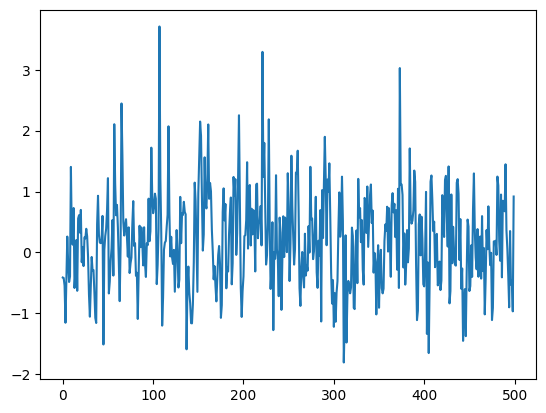

In [31]:
plt.plot(df.values[:,1])

In [55]:
sim_num = 5000
y0 = 0 * torch.ones(sim_num)
kappa_sim = 1 * torch.ones(sim_num)
beta_sim = 0 * torch.ones(sim_num)
sigma2_sim = 1 * torch.ones(sim_num)

lambda_sim = 0.07 * torch.ones(sim_num)
mu_sim = 1 * torch.ones(sim_num)
mod_check = MROUJ_simul_sample(obtime, 1000, y0, kappa_sim, beta_sim, sigma2_sim, lambda_sim, mu_sim)

In [67]:
mod_summary = MROUJ_summary2(mod_check)
mod_summary.size()

mod_summary = torch.clone((mod_summary - a) / (b - a))

print(torch.mean(net(mod_summary),0)[0:3])
print(torch.std(net(mod_summary),0)[0:3])

print(torch.mean(torch.exp(net(mod_summary)),0)[3:6])
print(torch.std(torch.exp(net(mod_summary)),0)[3:6])

tensor([ 1.0463, -0.0404,  1.0328], grad_fn=<SliceBackward0>)
tensor([0.1245, 0.0647, 0.1234], grad_fn=<SliceBackward0>)
tensor([0.0968, 1.2201], grad_fn=<SliceBackward0>)
tensor([0.0507, 0.1565], grad_fn=<SliceBackward0>)


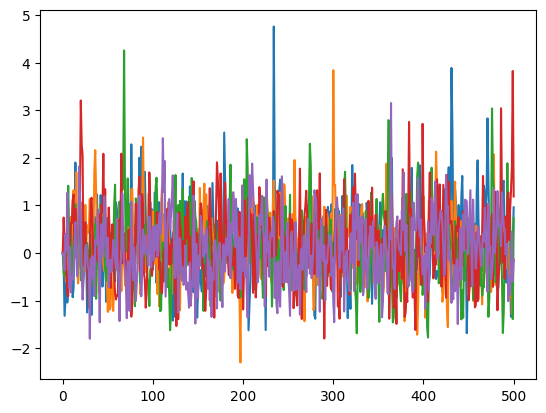

In [42]:
plt.plot(mod_check[0,:])
plt.plot(mod_check[1,:])
plt.plot(mod_check[2,:])
plt.plot(mod_check[3,:])
plt.plot(mod_check[40,:])
